## AARRR 프레임워크 분석을 통한 서비스 파악

### Acquisition

- 신규 가입자 수

In [ ]:
v_acc_user['created_at'] = pd.to_datetime(v_acc_user['created_at'])

# 년/월 단위로 그룹화하여 고유 사용자 수 집계
monthly_new_users = (
    v_acc_user.groupby(v_acc_user['created_at'].dt.to_period('M'))['id']
    .nunique()
    .reset_index()
)

# 열 이름 변경
monthly_new_users.columns = ['month', 'new_users']

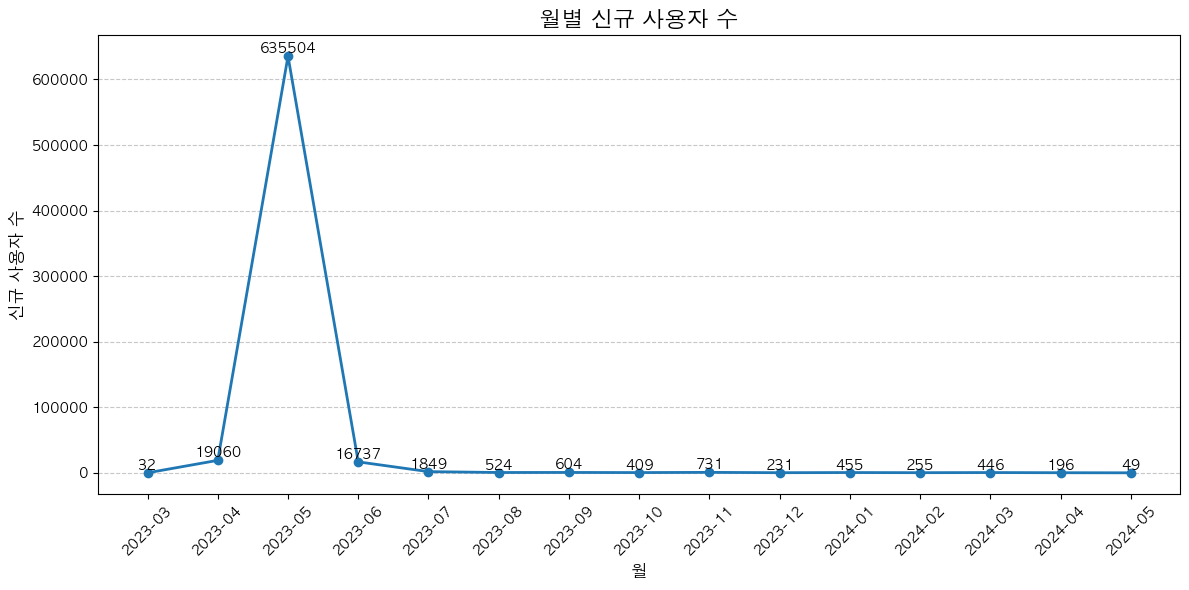

In [ ]:
graph_df = monthly_new_users.copy()
graph_df['month'] = monthly_new_users['month'].astype(str)

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(graph_df['month'], graph_df['new_users'], marker='o', linestyle='-', linewidth=2)

# 각 마커 위에 수치 표시
for i, value in enumerate(graph_df['new_users']):
    plt.text(i, value, str(value), fontsize=10, ha='center', va='bottom')

plt.xticks(rotation=45)
plt.title('월별 신규 사용자 수', fontsize=16)
plt.xlabel('월', fontsize=12)
plt.ylabel('신규 사용자 수', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- Hackle 이벤트 데이터에서 회원가입 페이지에 접속하고 회원가입을 완료한 사용자 비율

In [ ]:
#  event_datetime을 datetime 타입으로 변환
h_evt['event_datetime'] = pd.to_datetime(h_evt['event_datetime'])

# 회원가입 완료 이벤트 필터링
signup_events = h_evt[h_evt['event_key'] == 'complete_signup']

# 회원가입을 완료한 사용자 수
complete_signup_user_count = signup_events['session_id'].nunique()

# 회원가입 완료 이벤트 필터링
signup_page_events = h_evt[h_evt['event_key'] == 'view_signup']

# 회원가입 페이지에 접속한 사용자 수
enter_signup_user_count = signup_page_events['session_id'].nunique()

# 회원가입 페이지에 접속하고 회원가입을 완료한 사용자 비율
complete_signup_user_rate = (complete_signup_user_count / enter_signup_user_count) * 100

print(f"회원가입을 완료한 사용자 수: {complete_signup_user_count}")
print(f"회원가입 페이지에 접속하고 회원가입을 완료한 사용자 비율: {complete_signup_user_rate}")

회원가입을 완료한 사용자 수: 973
회원가입 페이지에 접속하고 회원가입을 완료한 사용자 비율: 12.779091147885474


### Activation

- 첫번째 투표 참여율
  1. vote table 이용

In [ ]:
# staff 필터링
only_user = v_acc_user[v_acc_user.is_staff != 1]

 # 가입한 총 유저 수 구하기
total_user_count = only_user.id.nunique()

#질문에 응답한 유저 수 구하기

# total_user_count에 있는 유저만 v_acc_user에서 필터링
# 필터링 결과 v_acc_user에 있는 user는 모두 total_user_count에 존재
filtered_data = v_acc_uqrec[v_acc_uqrec['user_id'].isin(v_acc_user['id'])]

answer_user_count = filtered_data.user_id.nunique()

In [ ]:
# 가입자 중 투표 참여율 구하기
(answer_user_count / total_user_count) * 100

0.7161614102870848

- 첫번째 투표 참여율
  2. hackle 이용

In [ ]:
hackle_properties_preprocessed = pd.read_csv('/Users/goayun/Desktop/고급프로젝트/data/hackle/hackle_properties_preprocessed.csv')

# 가입한 총 유저 수 구하기

# complete_signup 사건만 모아보기
complete_signup = hackle_events[hackle_events.event_key == 'complete_signup'][['event_datetime','event_key','session_id']]

# hackle_properties_preprocessed에서 매칭할 컬럼만 뽑기
match_df = hackle_properties_preprocessed[['session_id','user_id']]
#중복값 제거
match_df= match_df.drop_duplicates()

# user_id 붙이기
merged_df = pd.merge(complete_signup, match_df, on = 'session_id', how = 'left')

# 2023-07-18~ 2023-08-10에 가입한 총 유저 수 구하기
total_user_count = merged_df.user_id.nunique()

#질문에 응답한 유저 수 구하기

# click_question_start 사건만 모아보기
click_question_start = hackle_events[hackle_events.event_key == 'click_question_start'][['event_datetime','event_key','session_id']]

# user_id 붙이기
merged_question_df = pd.merge(click_question_start, match_df, on = 'session_id', how = 'left')

# 2023-07-18~ 2023-08-10에 가입한 유저만 필터링
filter_df = merged_question_df[merged_question_df['user_id'].isin(merged_df['user_id'])]

# 2023-07-18~ 2023-08-10에 가입한 유저 중 질문에 응답한 유저 수 구하기
answer_user_count = filter_df.user_id.nunique()

In [ ]:
# 계산
answer_user_count / total_user_count * 100

59.9290780141844

-  회원 가입 후, 사용자가 핵심 기능을 처음 이용하기까지 걸린 시간의 분포

In [ ]:
# 유저 가입 날짜 데이터셋
user_join_date = only_user[['id','created_at']]

# 컬럼 이름 변경
user_join_date = user_join_date.rename(columns = {'id': 'user_id', 'created_at':'join_date'})

# user_id별로 created_at이 가장 오래된 행만 필터링
oldest_row = v_acc_uqrec.loc[v_acc_uqrec.groupby('user_id')['created_at'].idxmin()][['user_id', 'created_at']]

oldest_row = oldest_row.rename(columns = {'created_at':'first_vote_date'})

# 두 데이터 셋 합치기
merged_df= pd.merge(user_join_date, oldest_row, on = 'user_id', how = 'right' )

# 데이터 타입 변경
merged_df['first_vote_date'] = pd.to_datetime(merged_df['first_vote_date'])
merged_df['join_date'] = pd.to_datetime(merged_df['join_date'])

# 활성화되기까지의 시간 컬럼 생성
merged_df['activation_time'] = merged_df['first_vote_date'] - merged_df['join_date']


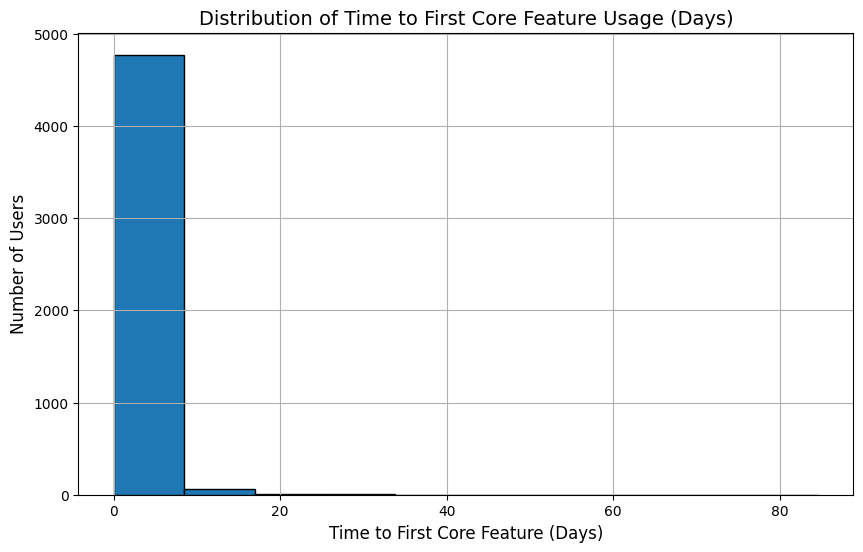

In [ ]:
# timedelta를 일단위로 변경
merged_df['activation_time_days'] = merged_df['activation_time'].dt.total_seconds() / (24 * 3600)

# 히스토그램: 가입 후 핵심 기능 사용까지 걸린 시간 (days 단위)
plt.figure(figsize=(10, 6))
plt.hist(merged_df['activation_time_days'], bins=10, edgecolor='black')
plt.title("Distribution of Time to First Core Feature Usage (Days)", fontsize=14)
plt.xlabel("Time to First Core Feature (Days)", fontsize=12)
plt.ylabel("Number of Users", fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
# 20일 이내 필터링
merged_7_df = merged_df[merged_df['activation_time_days']<= 7]

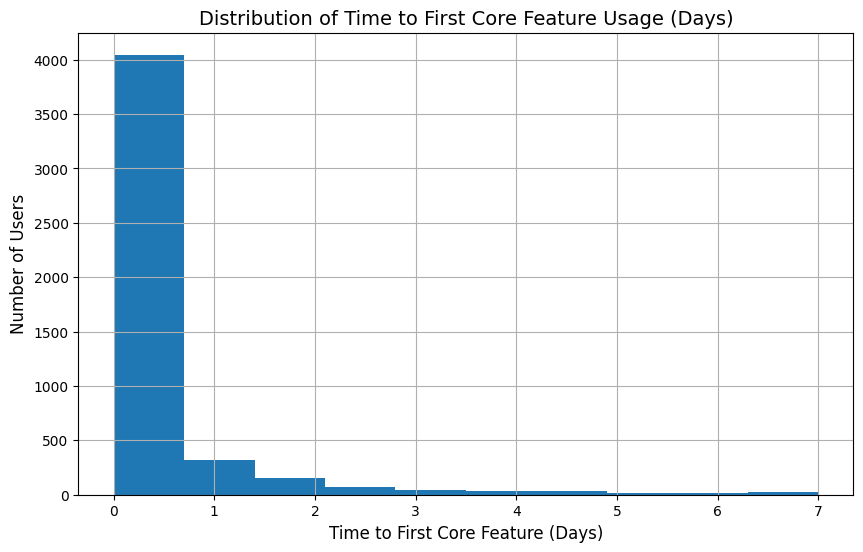

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(merged_7_df['activation_time_days'])
plt.title("Distribution of Time to First Core Feature Usage (Days)", fontsize=14)
plt.xlabel("Time to First Core Feature (Days)", fontsize=12)
plt.ylabel("Number of Users", fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
# 회원 가입 후 1일 이내 핵심기능을 하는 유저 비율 계산
count_less_than_1 = merged_df[merged_df['activation_time_days'] < 1].shape[0]

# 전체 행 수
total_count = merged_df.shape[0]

# 비율 계산
percentage_less_than_1 = (count_less_than_1 / total_count) * 100

In [ ]:
percentage_less_than_1

87.4613322334502

### Retention

#### DAU / WAU / MAU

Text(0, 0.5, 'user_count')

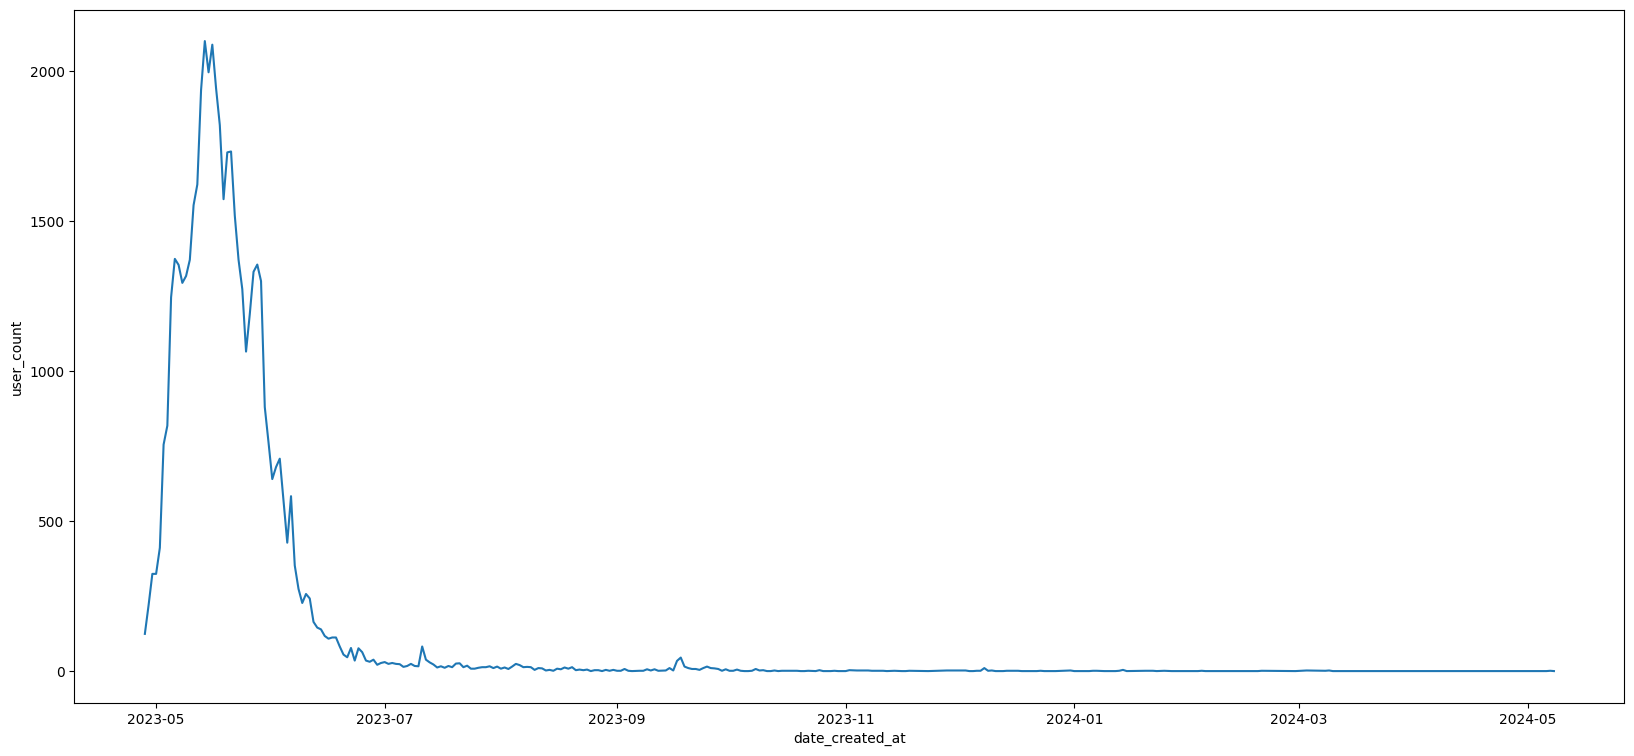

In [ ]:
## created_at을 date로 뽑아내서 일 기준 DAU 구하기
v_acc_uqrec['date_created_at'] = v_acc_uqrec['created_at'].dt.date
DAU =v_acc_uqrec.groupby('date_created_at')['user_id'].nunique().reset_index()

## 시각화
fig= plt.figure(figsize=(20,9))
sns.lineplot(data=DAU, x='date_created_at', y='user_id')
plt.ylabel('user_count')

Text(0, 0.5, 'user_count')

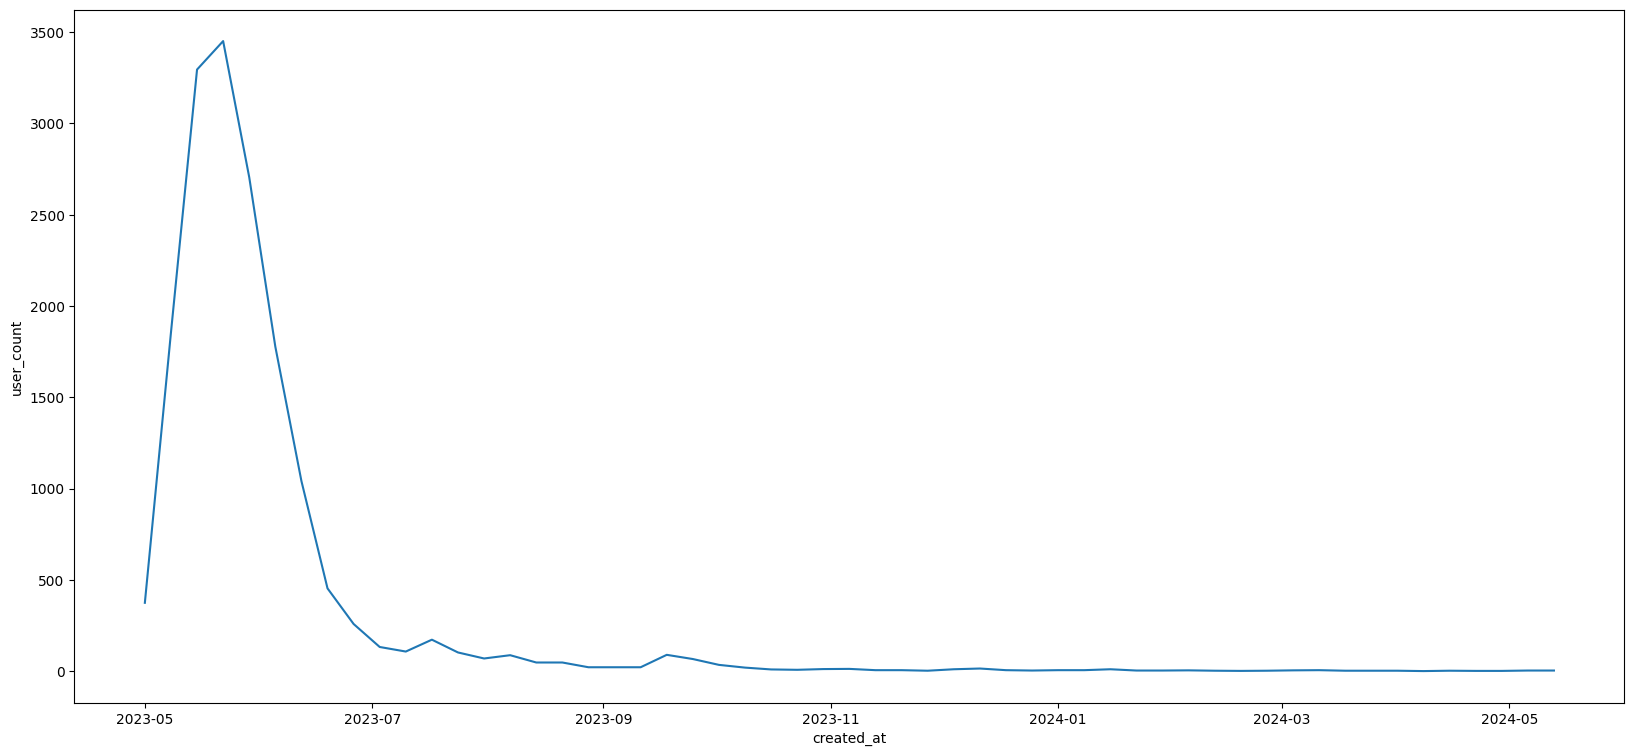

In [ ]:
# #created_at을 resample 이용하여 주별로 WAU 구하기
# 주 단위로 resample하려면, created_at을 인덱스로 설정해야 함
v_acc_uqrec.reset_index(inplace=True)
v_acc_uqrec.set_index('created_at', inplace=True)

# 주별로 user_id의 고유값 개수 계산 (월요일 기준으로 주간 시작)
WAU = v_acc_uqrec.resample('W-MON')['user_id'].nunique().reset_index()

## WAU 시각화
fig= plt.figure(figsize=(20,9))
sns.lineplot(data=WAU, x='created_at', y='user_id')
plt.ylabel('user_count')

Text(0, 0.5, 'user_count')

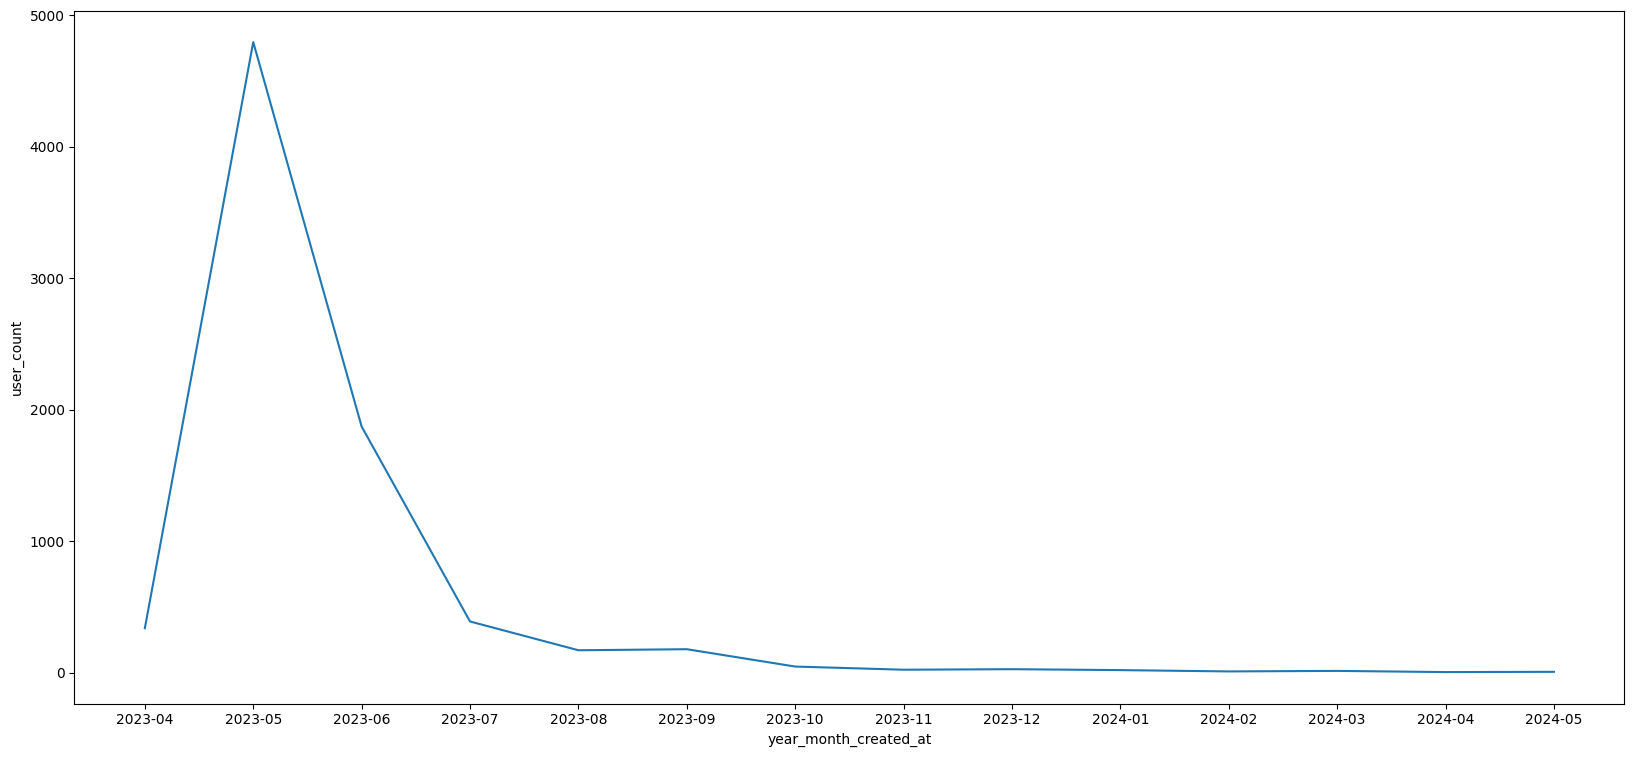

In [ ]:
## created_at을 year-month로 뽑아내서 일 기준 MAU 구하기
v_acc_uqrec = v_acc_uqrec.reset_index()
v_acc_uqrec['year_month_created_at'] = v_acc_uqrec['created_at'].dt.strftime("%Y-%m")
MAU =v_acc_uqrec.groupby('year_month_created_at')['user_id'].nunique().reset_index()
MAU

## MAU 시각화
fig= plt.figure(figsize=(20,9))
sns.lineplot(data=MAU, x='year_month_created_at', y='user_id')
plt.ylabel('user_count')

#### 유지율 (클래식 리텐션 Day1/Day7/Day30)

In [ ]:
## 필요한 데이터만 조회(일자, user_id)
retention_basic = (v_acc_uqrec[['created_at', 'user_id']]).copy()
retention_basic['created_at'] = retention_basic['created_at'].dt.date
retention_basic.head()

,created_at,user_id
0,2023-04-28,849436
1,2023-04-28,849436
2,2023-04-28,849436
3,2023-04-28,849436
4,2023-04-28,849436


In [ ]:
## 날짜 리스트
date_list = retention_basic['created_at'].unique()

## 날짜 형식 변환 (다시 한번 해줘야 에러 없음)
retention_basic['created_at'] = pd.to_datetime(retention_basic['created_at'])

## user_id 별 최초 활동일 계산
first_activity = retention_basic.groupby('user_id')['created_at'].min().reset_index()
first_activity.rename(columns={'created_at': 'first_active_date'}, inplace=True)

## 기준일을 day 0으로 설정하여 리텐션 계산 함수 정의
def calculate_retention_with_reference(retention_basic, reference_date, target_days):
    reference_date = pd.to_datetime(reference_date)

    # 최초 활동일이 기준일 이전인 유저만 고려
    first_activity_filtered = first_activity[first_activity['first_active_date'] <= reference_date]
    retention_basic_filtered = retention_basic[retention_basic['user_id'].isin(first_activity_filtered['user_id'])]

    # 기준일로부터의 경과일 계산
    retention_basic_filtered['days_since_reference'] = (retention_basic_filtered['created_at'] - reference_date).dt.days

    # 기준일에 기준 활동 유저 수 계산
    users_at_reference = first_activity_filtered['user_id'].nunique()

    # 타겟 날짜에 활동한 유저 수 계산
    retained_users = retention_basic_filtered[retention_basic_filtered['days_since_reference'] == target_days]['user_id'].nunique()

    # 리텐션 계산
    try:
      retention_rate = retained_users / users_at_reference * 100
    except ZeroDivisionError:
      retention_rate = 0
      print("ZeroDivisionError: 해당 날짜에 활동한 유저가 없어 분모가 0 입니다.")
    return retention_rate


In [ ]:
## day 1 리텐션 도출
retention_list = []
for date in retention_basic['created_at'].unique():
  retention_list.append(calculate_retention_with_reference(retention_basic, date, 1))

<Axes: xlabel='created_at', ylabel='retention'>

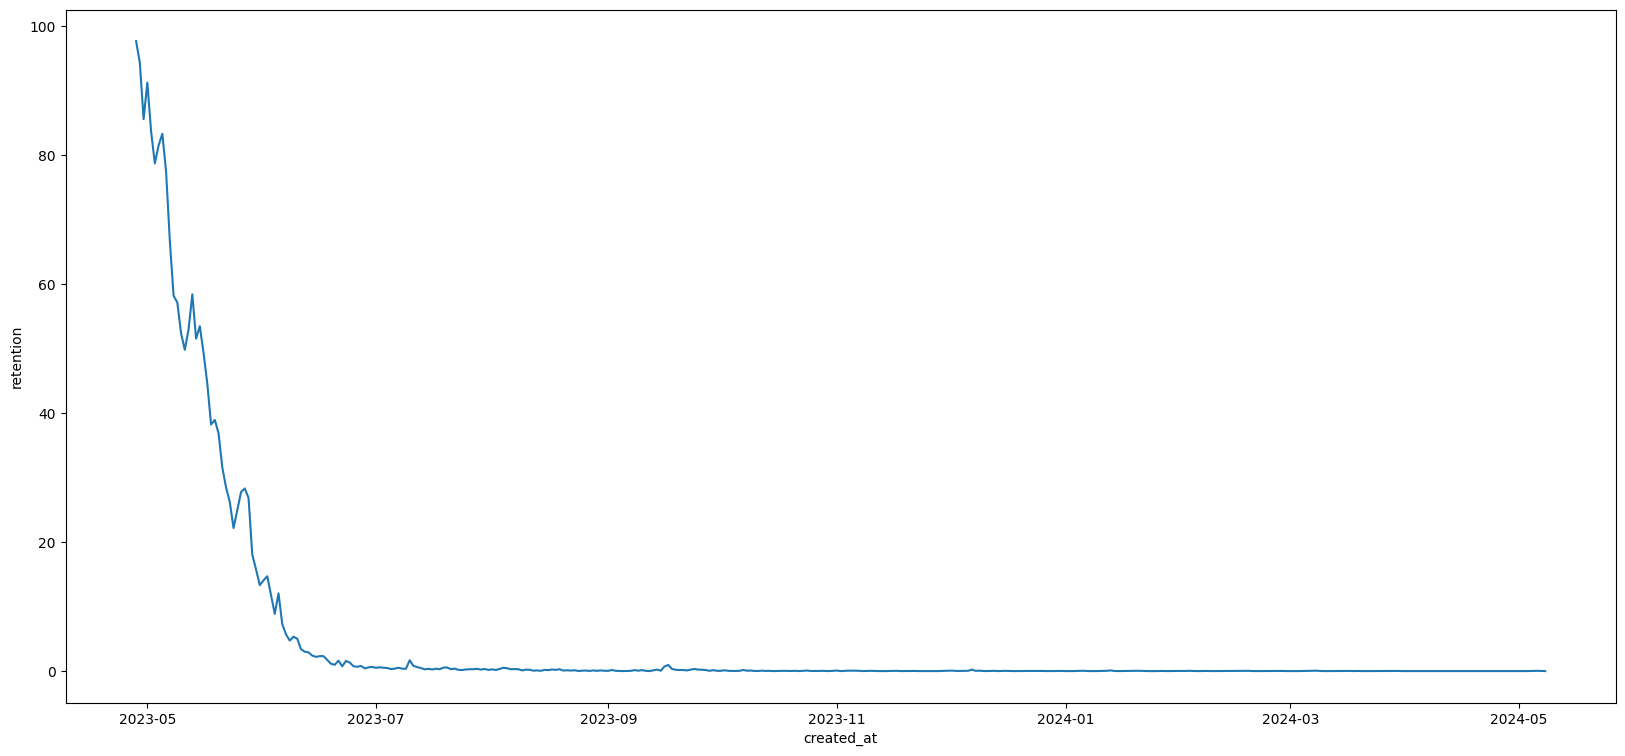

In [ ]:
## day 1 리텐션 데이터 프레임으로 만들기
day1 ={}
day1['created_at'] = list(retention_basic['created_at'].unique())
day1['retention'] = retention_list

day1 = pd.DataFrame(day1)

## day 1 리텐션 시각화
fig= plt.figure(figsize=(20,9))
sns.lineplot(data=day1, x='created_at', y='retention')

In [ ]:
## day 7 리텐션 도출
retention_list = []
for date in retention_basic['created_at'].unique():
  retention_list.append(calculate_retention_with_reference(retention_basic, date, 7))

<Axes: xlabel='created_at', ylabel='retention'>

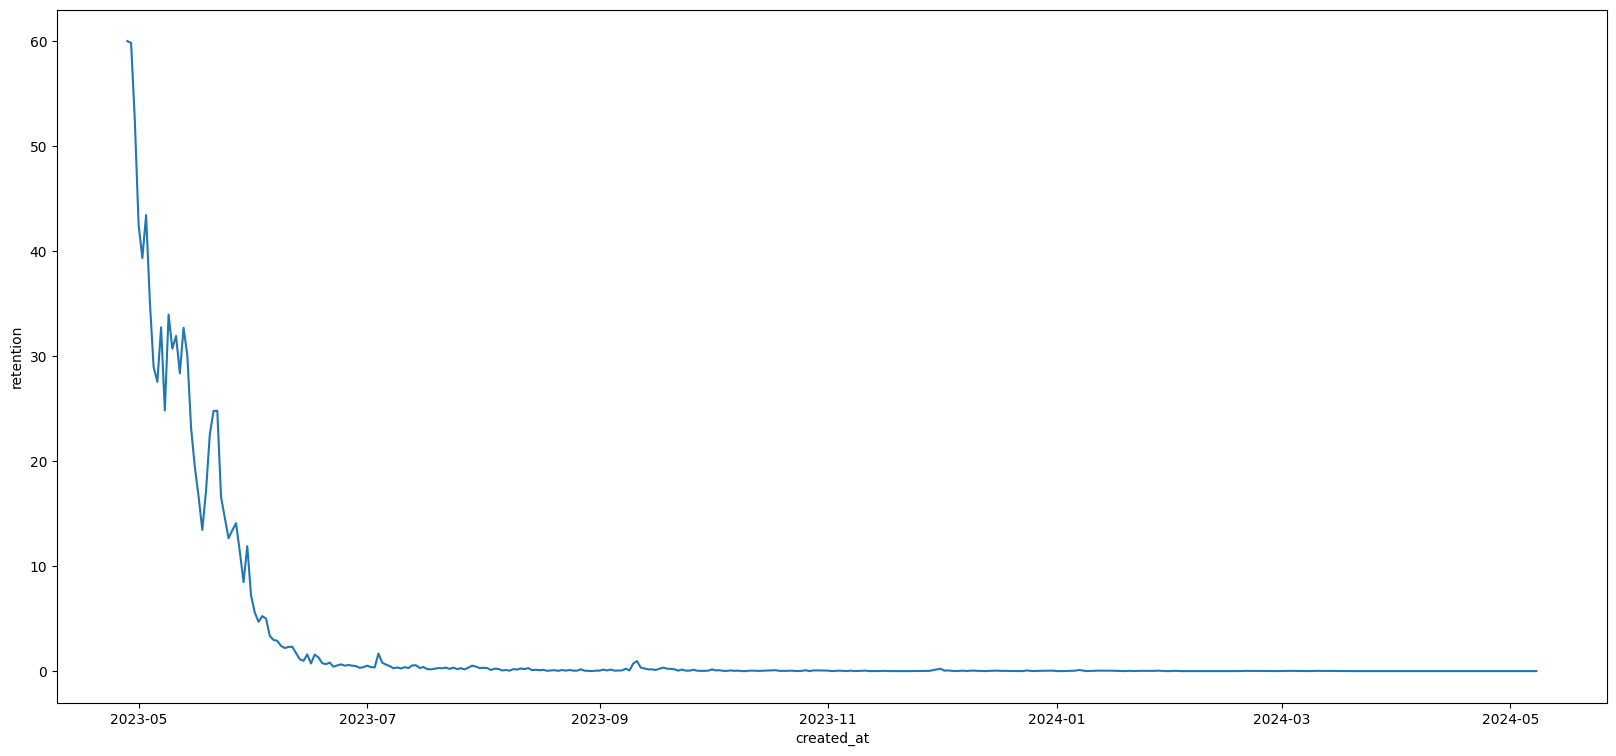

In [ ]:
## day 7 리텐션 데이터 프레임으로 만들기
day7 ={}
day7['created_at'] = list(retention_basic['created_at'].unique())
day7['retention'] = retention_list

day7 = pd.DataFrame(day7)

## day 7 리텐션 시각화
fig= plt.figure(figsize=(20,9))
sns.lineplot(data=day7, x='created_at', y='retention')

In [ ]:
## day 30 리텐션 도출
retention_list = []
for date in retention_basic['created_at'].unique():
  retention_list.append(calculate_retention_with_reference(retention_basic, date, 30))

<Axes: xlabel='created_at', ylabel='retention'>

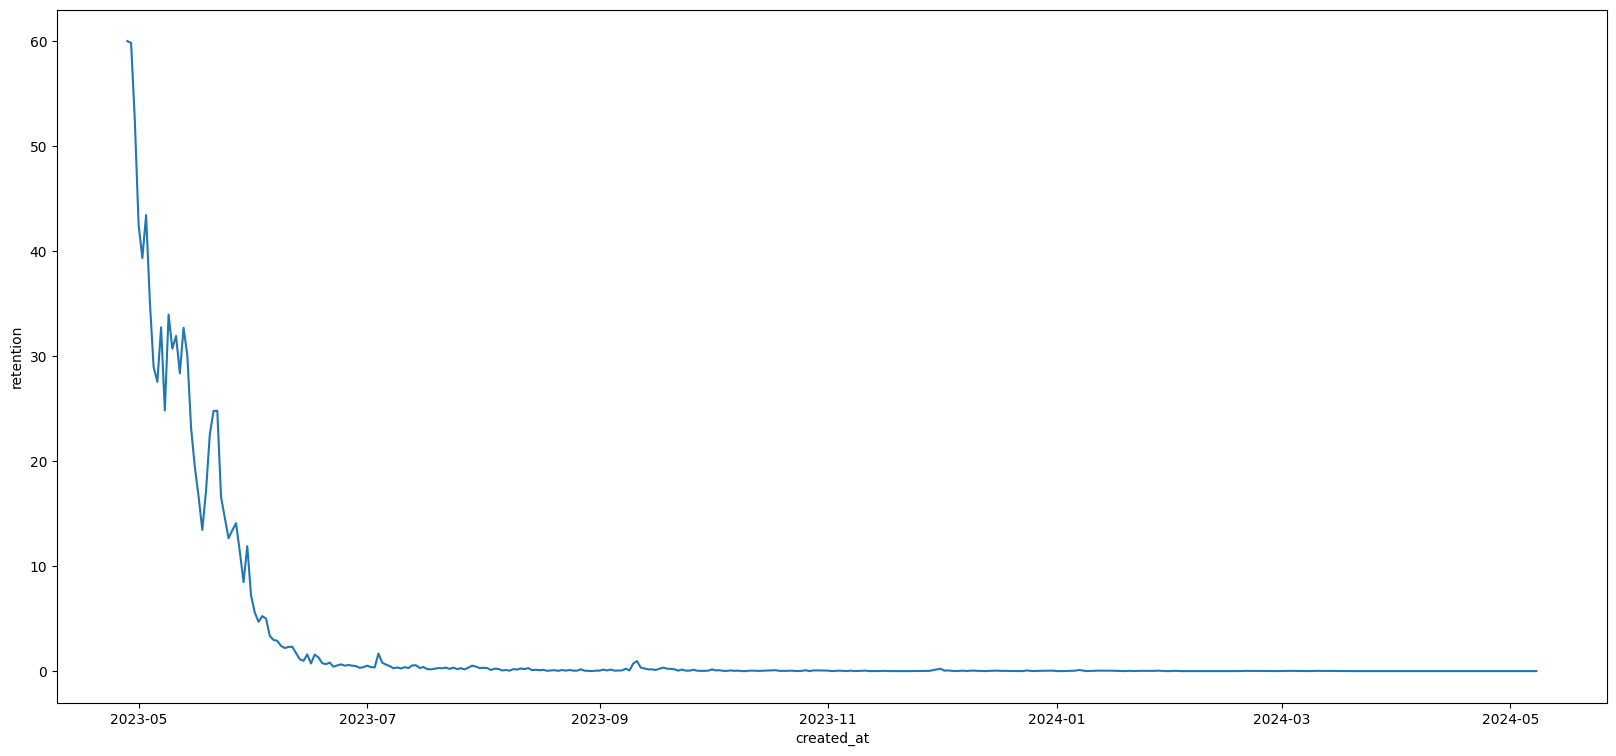

In [ ]:
## day 30 리텐션 데이터 프레임으로 만들기
day30 ={}
day30['created_at'] = list(retention_basic['created_at'].unique())
day30['retention'] = retention_list

day30 = pd.DataFrame(day30)

## day 30 리텐션 시각화
fig= plt.figure(figsize=(20,9))
sns.lineplot(data=day7, x='created_at', y='retention')

#### 탈퇴건수

Text(0, 0.5, 'withdraw_user_count')

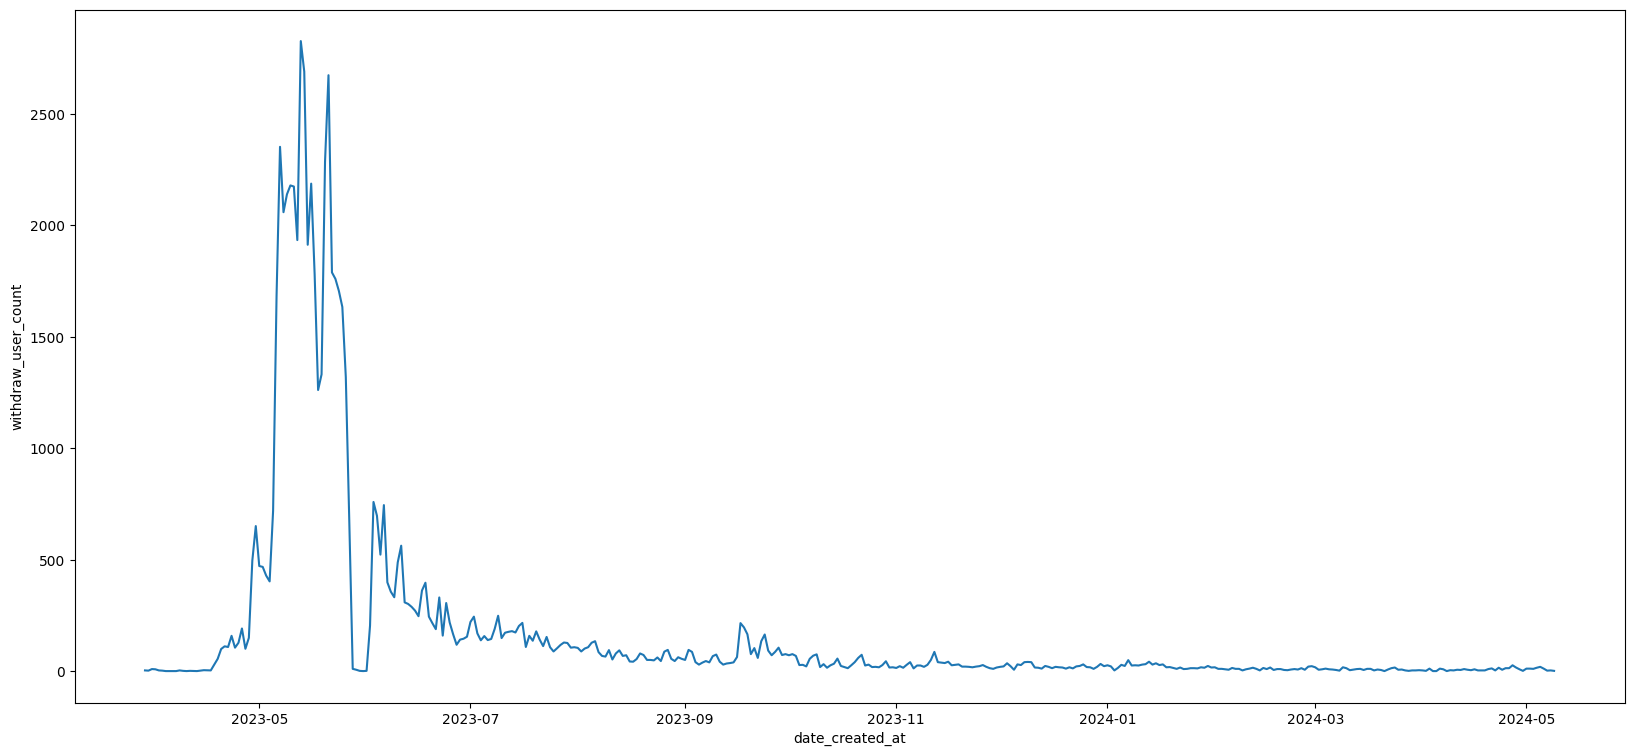

In [ ]:
## date 기준으로 뽑아주기
v_acc_uwd['created_at'] =pd.to_datetime(v_acc_uwd['created_at'])
v_acc_uwd['date_created_at'] = v_acc_uwd['created_at'].dt.date

## date 기준으로 탈퇴건수 구하기
withdraw_count = pd.DataFrame(v_acc_uwd.groupby('date_created_at')['id'].count()).reset_index()
withdraw_count

## 탈퇴건수 시각화
fig= plt.figure(figsize=(20,9))
sns.lineplot(data=withdraw_count, x='date_created_at', y='id')
plt.ylabel('withdraw_user_count')

#### 탈퇴율

C:\Users\jungh\AppData\Local\Temp\ipykernel_18632\3278066751.py:39: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  current_users['create_account_cumsum'] = current_users['create_account_cumsum'].fillna(method='ffill')


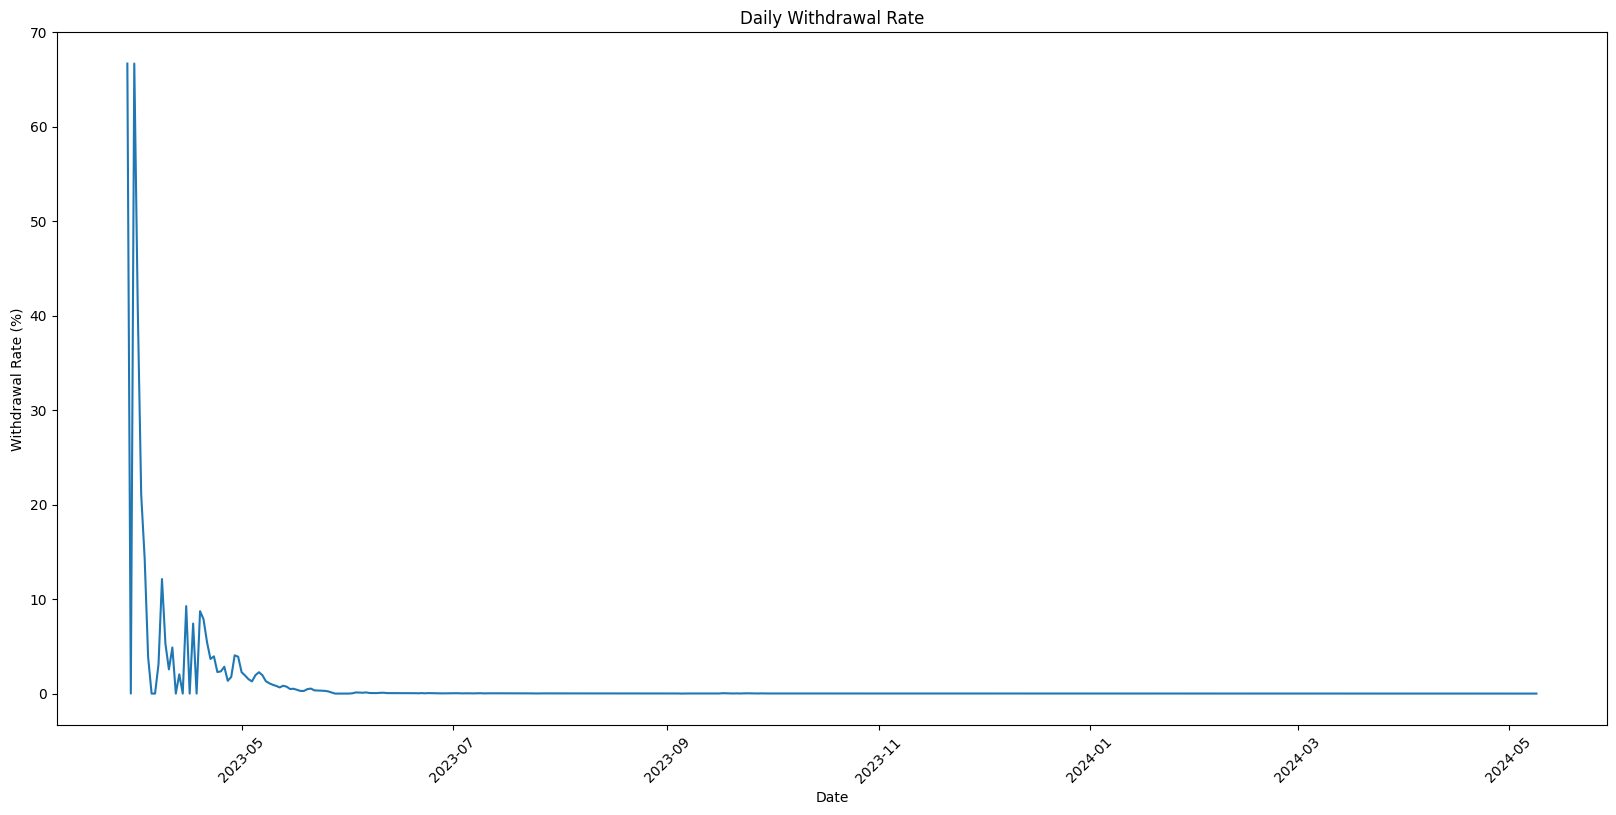

In [ ]:
def process_account_creation(v_acc_user):
    """생성된 계정의 일자별 누적 사용자 수를 계산"""
    create_account_users = v_acc_user[['id', 'created_at']].copy()
    create_account_users['created_at'] = pd.to_datetime(create_account_users['created_at'])
    create_account_users['date_created_at'] = create_account_users['created_at'].dt.date

    # 날짜별 고유 유저 수와 누적 유저 수 계산
    create_account_users_temp = (
        create_account_users.groupby('date_created_at')['id']
        .nunique()
        .reset_index(name='unique_users')
    )
    create_account_users_temp['create_account_cumsum'] = create_account_users_temp['unique_users'].cumsum()

    return create_account_users_temp[['date_created_at', 'create_account_cumsum']]

def process_withdrawal(v_acc_uwd):
    """탈퇴한 계정의 일자별 누적 탈퇴 사용자 수를 계산"""
    withdraw = v_acc_uwd[['id', 'created_at']].copy()
    withdraw['created_at'] = pd.to_datetime(withdraw['created_at'])
    withdraw['date_created_at'] = withdraw['created_at'].dt.date

    # 날짜별 고유 유저 수와 누적 유저 수 계산
    withdraw_temp = (
        withdraw.groupby('date_created_at')['id']
        .nunique()
        .reset_index(name='unique_users')
    )
    withdraw_temp['withdraw_cumsum'] = withdraw_temp['unique_users'].cumsum()

    return withdraw_temp[['date_created_at', 'withdraw_cumsum']]

def calculate_withdraw_rate(create_account_users_temp, withdraw_temp, withdraw_count):
    """탈퇴율을 계산하는 함수"""
    # 두 개의 누적 데이터프레임을 병합
    current_users = pd.merge(create_account_users_temp, withdraw_temp, on='date_created_at', how='outer')

    # 결측값을 이전 행의 값으로 채움 (전날의 누적 사용자 수와 누적 탈퇴 수 유지)
    current_users['create_account_cumsum'] = current_users['create_account_cumsum'].fillna(method='ffill')
    current_users['withdraw_cumsum'] = current_users['withdraw_cumsum'].fillna(0)

    # 총 유저 수 계산
    current_users['total_users'] = current_users['create_account_cumsum'] - current_users['withdraw_cumsum']

    # withdraw_count 테이블과 병합 후 탈퇴율 계산
    withdraw_count = withdraw_count.rename(columns={'id': 'withdraw_count'})
    withdraw_rate = pd.merge(current_users, withdraw_count, on='date_created_at', how='left')
    withdraw_rate['withdraw_rate'] = round((withdraw_rate['withdraw_count'] / withdraw_rate['total_users']) * 100, 2)

    # 결측값을 0으로 채움
    withdraw_rate['withdraw_rate'] = withdraw_rate['withdraw_rate'].fillna(0)

    return withdraw_rate

def visualize_withdraw_rate(withdraw_rate):
    """탈퇴율을 시각화하는 함수"""
    fig = plt.figure(figsize=(20, 9))
    sns.lineplot(data=withdraw_rate, x='date_created_at', y='withdraw_rate')
    plt.title('Daily Withdrawal Rate')
    plt.xlabel('Date')
    plt.ylabel('Withdrawal Rate (%)')
    plt.xticks(rotation=45)
    plt.show()

# === 메인 실행 부분 ===
create_account_users_temp = process_account_creation(v_acc_user)
withdraw_temp = process_withdrawal(v_acc_uwd)
withdraw_rate = calculate_withdraw_rate(create_account_users_temp, withdraw_temp, withdraw_count)
visualize_withdraw_rate(withdraw_rate)

### Revenue

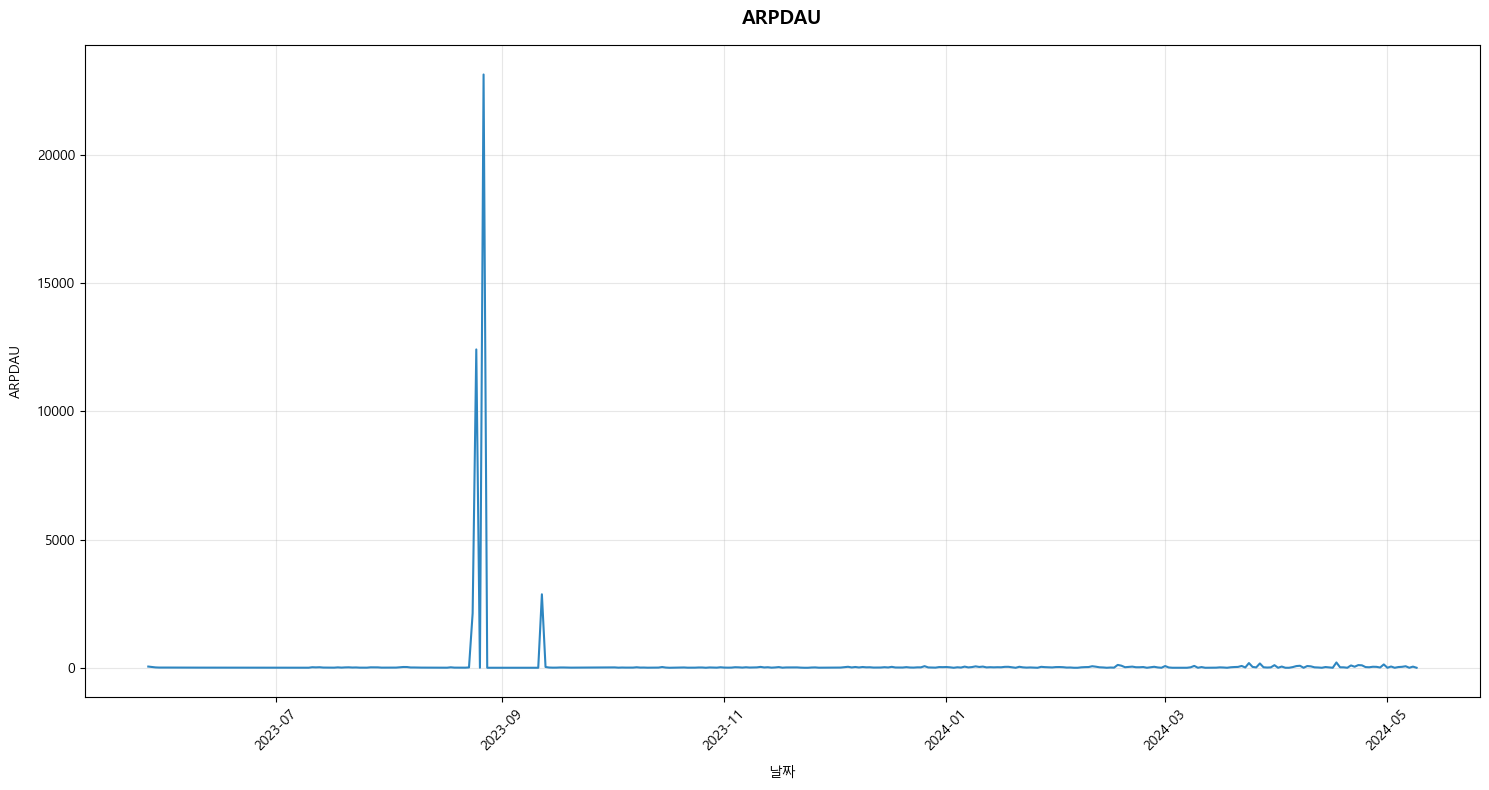

In [ ]:
v_acc_atd['attendance_date'] = pd.to_datetime(v_acc_atd['attendance_date']).dt.date

date_range = pd.date_range(
    start=v_acc_atd['attendance_date'].min(),
    end=v_acc_atd['attendance_date'].max(),
    freq='D'
).date

daily_users = pd.DataFrame({'date': date_range})

# DAU
dau = v_acc_atd.groupby('attendance_date')['user_id'].nunique().reset_index()
dau.columns = ['date', 'DAU']

# 빈 날짜 포함 병합
daily_users = daily_users.merge(dau, on='date', how='left')
daily_users['DAU'] = daily_users['DAU'].fillna(0)

replace_dict = {
    'heart.777': 777,
    'heart.200': 200,
    'heart.1000': 1000,
    'heart.4000': 4000
}
v_acc_pay['productId'].replace(replace_dict, inplace=True)

v_acc_pay['created_at'] = pd.to_datetime(v_acc_pay['created_at']).dt.date

# 일별 매출 계산
daily_revenue = v_acc_pay.groupby('created_at')['productId'].sum().reset_index()
daily_revenue.columns = ['date', 'Revenue']

# 연속된 날짜 포함하여 매출 데이터 생성
daily_revenue = pd.DataFrame({'date': date_range}).merge(
    daily_revenue,
    on='date',
    how='left'
)
daily_revenue['Revenue'] = daily_revenue['Revenue'].fillna(0)

arpdau_df = pd.merge(daily_users, daily_revenue, on='date', how='outer')
arpdau_df = arpdau_df.fillna(0)

# ARPDAU 계산, DAU가 0인 경우 ARPDAU도 0
arpdau_df['ARPDAU'] = np.where(
    arpdau_df['DAU'] == 0,
    0,
    arpdau_df['Revenue'] / arpdau_df['DAU']
)

plt.figure(figsize=(15, 8))
plt.plot(arpdau_df['date'], arpdau_df['ARPDAU'],
         linewidth=1.5,
         color='#2E86C1')
plt.title('ARPDAU',
         pad=15,
         fontsize=14,
         fontweight='bold')
plt.xlabel('날짜', labelpad=10)
plt.ylabel('ARPDAU', labelpad=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Referral

- 초대를 받고 가입을 하는 사용자 수

In [ ]:
invited_users = v_acc_ucon[v_acc_ucon['invite_user_id_list'] != '[]']

invited_user_count = invited_users['user_id'].nunique()

print(f"초대를 받고 가입을 하는 사용자 수: {invited_user_count}")

초대를 받고 가입을 하는 사용자 수: 1158


In [ ]:
# 초대를 받은 사용자 ID 목록 추출
invited_user_ids = invited_users['user_id'].unique()

filtered_registration_data = v_acc_user[v_acc_user['id'].isin(invited_user_ids)]

# 필요한 열만 포함된 데이터프레임 생성
final_data = filtered_registration_data[['id', 'created_at']]

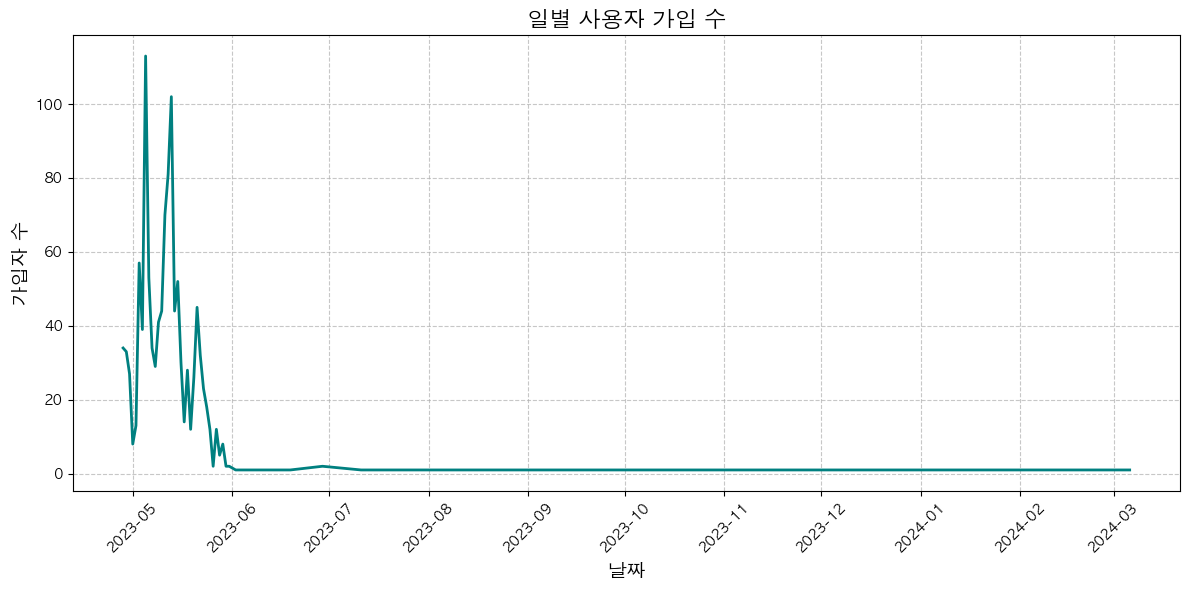

In [ ]:
# 'created_at' 열에서 날짜(Date) 추출
final_data['date'] = final_data['created_at'].dt.date

# 일별 가입자 수 집계
daily_counts = final_data.groupby('date').size()

# 일별 가입자 수 그래프 그리기
plt.figure(figsize=(12, 6))
daily_counts.plot(kind='line', linestyle='-', color='teal', linewidth=2)

# 그래프 제목과 축 라벨 설정
plt.title('일별 사용자 가입 수', fontsize=16)
plt.xlabel('날짜', fontsize=14)
plt.ylabel('가입자 수', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
